# TRISEP ML Tutorial Part 1: Project overview and data visualization and streaming tutorial


## Project Overview
I will assume everybody here is roughly familiar with physics of neutrinos and Water Cherenkov detectors.
In this project we will tackle the task of classification of neutrino type ($\nu_e$ or $\nu_\mu$) or rather the charged leptons resulting from the nuclear scatter ($e$ and  $\mu$) as well as an irreducible background from neutral current $\gamma$ production. The dataset comes from simulated Water Cherenkov detector called NuPRISM. NuPRISM is a proposed 'intermediate' detector for the Hyper-Kamiokande project. The detector has a cylindrical geometry and can be lowered and raised in a shaft to sample different energy distribution of incoming neutrinos! ![NUPRISM](../img/NUPRISM_diag.png)

The cylinder wall or 'barrel' and end-caps are lined with 'multi-PMT' or 'mPMT' modules arranged in a rectangular grid. Each mPMT is a dome with 19 PMTs arranged in two rings and one at the center:![mPMT](../img/mPMT.png)

Here is an event display where the barrel was 'unrolled':
![eventdisp](../img/ev_disp.png) - you can clearly see a Cherenkov ring appearing
The 'brightness' corresponds to charge collected by each PMT. Each PMT also tells us the arrival time of the signal.

In this part of the we will take a look at the data and how to organize streaming it in batches so that we can feed it to our neural model

Ok! now that you are back lets see if we can see the dataset:

In [1]:
!ls /fast_scratch/TRISEP_data/NUPRISM.h5 -lh

-rw-r--r-- 1 ubuntu ubuntu 82G Jul 31 08:38 /fast_scratch/TRISEP_data/NUPRISM.h5


Let's quickly look what's inside... - import h5py, numpy etc and open for reading

In [2]:
import numpy as np
import os, time
import h5py

In [3]:
f=h5py.File("/fast_scratch/TRISEP_data/NUPRISM.h5","r")

`keys()` will give us all the hdf5 datasets stored in the file

In [4]:
f.keys()

KeysView(<HDF5 file "NUPRISM.h5" (mode r)>)

Let's look at the shapes of the data:

In [5]:
f['labels'].shape

(900000,)

In [6]:
f['event_data'].shape

(900000, 16, 40, 38)

We have 900k simulated scattering events here! labels are 0, 1, 2 for $\gamma$,$e$ and $\mu$ respectively. The 'event_data' contains only the barrel portion of the tank which has been 'unrolled'. The first dimension (900k) enumerates over the events, the second two dimensions (16,40) enumerate over the row and column in the module 'grid'. Finally last two dimensions enumerate over the PMT within the module (again there are 19 in each mPMT module) first 19 entries correspond to charge collected on a given PMT and last 19 correspond to the time.



Note that the object returned by the subscript looks like an array - we can subscript it and even do fancy indexing:

In [7]:
f['event_data'][[42,1984],:,:,:]

array([[[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [1.0128782e+00, 0.0000000e+00, 7.9039353e-01, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         ...,
         [8.0274928e-01, 0.0000000e+00, 0.0000000e+00, ...,
          9.8659998e+02, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 9.8229999e+02, 0.0000000e+00]],

        [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 1.0651000e+03, 0.0000000e+00],
         [4.4163281e-01, 0.0000000e+00, 0.0000000e+00, ...,
          0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, .

 In fact the object is not a numpy array -it is a hdf5 `Dataset` object - the data itself lives on disk until we request it

In [8]:
type(f['event_data'])

h5py._hl.dataset.Dataset

The size of the dataset will make it difficult to load all at once into memory on many systems

In [9]:
print("Size of the bulk of the data is {:.1f} GB".format( (f['event_data'].size * 4 / (1024**3)) ))

Size of the bulk of the data is 81.5 GB


One important feature of the dataset it is uncompressed and contiguous or 'unchunked':

In [10]:
print("dataset chunks: {} compression: {}".format(f['event_data'].chunks,f['event_data'].compression))

dataset chunks: None compression: None


The dataset has been prepared as contiguous and uncompressed so that we are not obliged to load it all in memory but we can access it very fast. BUT it will take more spave on disk. In the next section we will see an example of how to deal with datasets with these sizes.

## Pytorch Dataset object

Let's import and create a Dataset object - you are welcome to look at the [source](/edit/utils/data_handling.py)

First we need to include the sources in the python search path

In [11]:
import os,sys
currentdir = os.getcwd()
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 

In [12]:
from utils.data_handling import WCH5Dataset

The class derives from the torch Dataset object. The two heavy lifters are the __init__ function and __getitem__ function.
Let's look at what init does:  
       
```python
        self.f=h5py.File(path,'r')
        hdf5_event_data = self.f["event_data"]
        hdf5_labels=self.f["labels"]
        hdf5_energies=self.f["energies"]

        event_data_shape = hdf5_event_data.shape
        event_data_offset = hdf5_event_data.id.get_offset()
        event_data_dtype = hdf5_event_data.dtype         
```
      
-here we opened the file and got the offsets, shapes, and data types of the datasets. Why are we doing this? This is because the hdf5 file is uncompressed and the datasets within are contiguous - this allows us to do memory mapping of the file. This is important with large datasets like this - where we are most like not going to be able to load everything into memory. Withh memory map we can only load what we need, when we need it


The memory map itself happens here:

```python
        self.event_data = np.memmap(path, mode='r', 
                                    shape=event_data_shape, 
                                    offset=event_data_offset, 
                                    dtype=event_data_dtype) 
```
We will just load the labels and energies into memory - this is only several MB
```python
        self.labels = np.array(hdf5_labels)
        self.energies = np.array(hdf5_energies)
```

The rest of __init__ function computes indices for training, validation and testing sets, based on a random (but consistent) shuffle of events - this will be useful later when trainnig our model. We also provide a facility to only use a subset of the dataset. Why may we want to access the records in the file in randomized order. This really depends on how the dataset was created - for instance here we just concatenated a bunch of simulation files in order - so the examples are in blocks:

In [13]:
f['labels'][0::1000]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,

We will definitelly want to avoid showing the model only photons then only electrons and then only muons - hence the index 
shuffling:
```python
    np.random.shuffle(indices)

    self.train_indices = indices[:-n_val-n_test]
    self.val_indices = indices[-n_test-n_val:-n_test]
    self.test_indices = indices[-n_test:]
````

Finally we have the __getitem__ method - this provides functionality for the subscript [] operator. Only here we actually load the event_data that was requested:  
```python
        return np.array(self.event_data[index,:]),  self.labels[index], self.energies[index][0]       
```
-we return a tuple with three elements - first is the event 'image', second is the label, and third is the 'true' energy of the generated particle. If you look at the code you will notice that there is also a provision for providing a transform. This is very useful if you want to do data augmentation on-the-fly. E.g. we could flip the images to 'populate' the dataset to reflect the variability we expect in the dataset we will want to apply the model. We could also use it to pre-process the data on-the fly as well.


finally we need the len method - this just needs to return how many exmples we have in the dataset

Ok let's instantiate the dataset and ask it for a few examples:

In [14]:
dset=WCH5Dataset("/fast_scratch/TRISEP_data/NUPRISM.h5",val_split=0.1,test_split=0.1)

In [15]:
len(dset)

900000

Let's import matplotlib and tell it to plot inline in the jupyter notebook

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib

Let's get some random event and label from the training dataset:

In [17]:
event, label, energy=dset[dset.train_indices[1984]]

In [18]:
print("Label {} and energy: {} (MeV) ".format(label,energy))

Label 0 and energy: 483.4703063964844 (MeV) 


In [19]:
f.filename

'/fast_scratch/TRISEP_data/NUPRISM.h5'

We are going to plot only the PMT charge for the 'center' PMT in mPMT modules - i believe this is at channel 18

class is 0


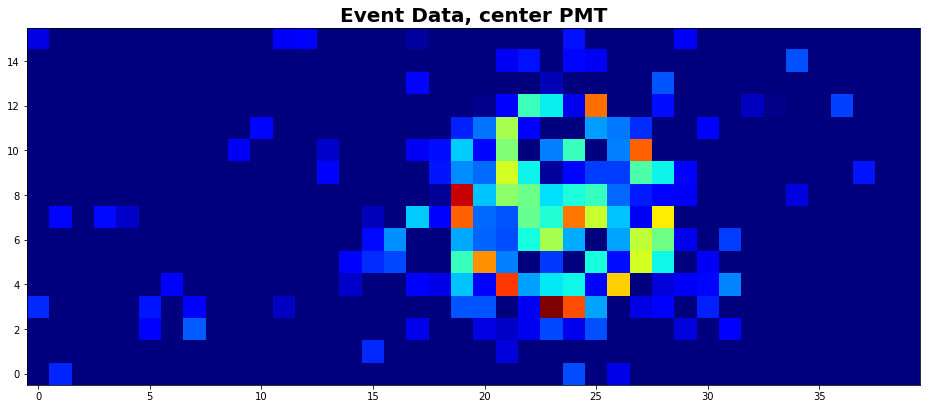

In [20]:
fig, ax = plt.subplots(figsize=(16,8),facecolor='w')
plt.imshow(event[:,:,18],cmap='jet',origin='lower')
ax.set_title('Event Data, center PMT',fontsize=20,fontweight='bold')
print('class is {}'.format(label))
plt.show()

We can also display the sum charge in the PMT

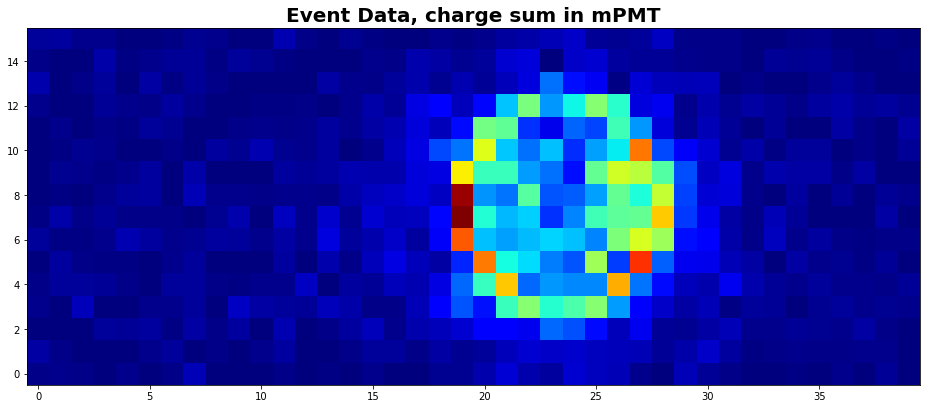

In [21]:
fig, ax = plt.subplots(figsize=(16,8),facecolor='w')
plt.imshow(np.sum(event[:,:,0:19],axis=-1),cmap='jet',origin='lower')
ax.set_title('Event Data, charge sum in mPMT',fontsize=20,fontweight='bold')
plt.show()

Let's plot this in a slightly nicer way - this is not 100% eact - we will put each PMT on a grid and display that

In [22]:
from utils.plot_utils import get_plot_array

In [23]:
event[:,:,0:19].shape

(16, 40, 19)

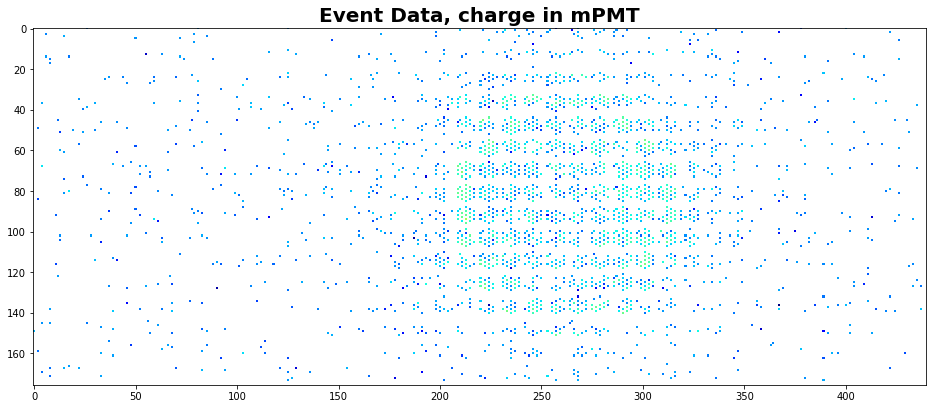

In [24]:
fig, ax = plt.subplots(figsize=(16,8),facecolor='w')
plt.imshow(get_plot_array(event[:,:,0:19]),
           origin="upper",
           cmap="jet",
           norm=matplotlib.colors.LogNorm(vmax=np.amax(event),
                                          clip=True))
ax.set_title('Event Data, charge in mPMT',fontsize=20,fontweight='bold')
plt.show()

Always try to learn as much as possible about the dataset before throwing ML at it. Let's quickly histogram the charges. We won't load the full dataset but taking few thousand should be fine (since we have 12k PMTs)

In [27]:
%%time
data_to_plot=dset[dset.train_indices[0:2000]]

CPU times: user 104 ms, sys: 404 ms, total: 508 ms
Wall time: 319 ms


In [28]:
data_to_plot_events=data_to_plot[0]
data_to_plot_labels=data_to_plot[1]
data_to_plot_energies=data_to_plot[2]

Let's plot the charge distributions

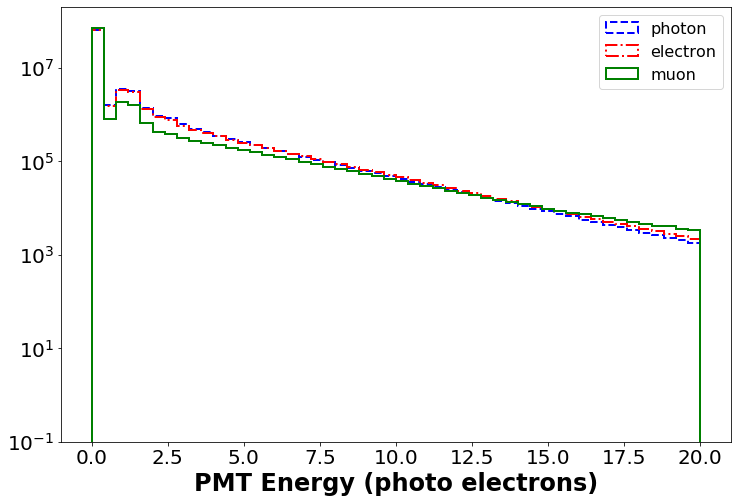

In [28]:
fig, ax = plt.subplots(figsize=(12,8),facecolor="w")

ax.tick_params(axis="both", labelsize=20)

bins=np.linspace(0.0,20.0,51)
values, bins, patches = ax.hist(data_to_plot_events[np.where(data_to_plot_labels==0)][:,:,:,0:19].flatten(),
                                bins=bins, 
                                label= 'photon', color='blue', linestyle='--', linewidth=2,
                                log=True,
                                histtype='step')

values, bins, patches = ax.hist(data_to_plot_events[np.where(data_to_plot_labels==1)][:,:,:,0:19].flatten(),
                                bins=bins, 
                                label= 'electron', color='red', linestyle='-.', linewidth=2,
                                log=True,
                                histtype='step')

values, bins, patches = ax.hist(data_to_plot_events[np.where(data_to_plot_labels==2)][:,:,:,0:19].flatten(),
                                bins=bins, 
                                label= 'muon', color='green', linewidth=2,
                                log=True,
                                histtype='step')
ax.set_xlabel('PMT Energy (photo electrons)',fontweight='bold',fontsize=24,color='black')

ax.legend(prop={'size': 16})

plt.show()

Now plot the time histogram -notice anything strange?

Let's also plot the total energy in the event and also the true particle energy

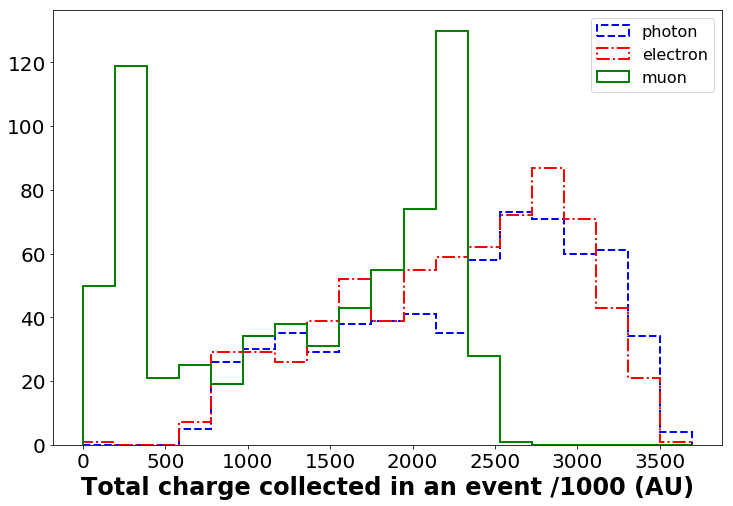

In [30]:
e_sum_gamma=np.sum(data_to_plot_events[np.where(data_to_plot_labels==0)][:,:,:,19:],axis=(1,2,3))/1000.0
e_sum_e=np.sum(data_to_plot_events[np.where(data_to_plot_labels==1)][:,:,:,19:],axis=(1,2,3))/1000.0
e_sum_mu=np.sum(data_to_plot_events[np.where(data_to_plot_labels==2)][:,:,:,19:],axis=(1,2,3))/1000.0


fig, ax = plt.subplots(figsize=(12,8),facecolor="w")

max_bin=max(np.amax(e_sum_gamma),np.amax(e_sum_e),np.amax(e_sum_mu))
bins_esum=np.linspace(0.0,max_bin,20)


ax.tick_params(axis="both", labelsize=20)


values, bins, patches = ax.hist(e_sum_gamma,
                                bins=bins_esum, 
                                label= 'photon', color='blue', linestyle='--', linewidth=2,
                                histtype='step')
values, bins, patches = ax.hist(e_sum_e,
                                bins=bins_esum, 
                                label= 'electron', color='red', linestyle='-.', linewidth=2,
                                histtype='step')
values, bins, patches = ax.hist(e_sum_mu,
                                bins=bins_esum, 
                                label= 'muon', color='green', linewidth=2,
                                histtype='step')

ax.set_xlabel('Total charge collected in an event /1000 (AU)',fontweight='bold',fontsize=24,color='black')

ax.legend(prop={'size': 16})

plt.show()



Muons seem to look very different - but is that expected?

## DataLoader objects and streaming the data

Now lets actually create DataLoader objects - one for each training, validation and testing set - but each DataLoader uses the same dataset -that way we keep only one open file (this is the 'standard' pytorch way)

In [31]:
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
train_iter=DataLoader(dset,batch_size=64,shuffle=False,sampler=SubsetRandomSampler(dset.train_indices),num_workers=4)
val_iter=DataLoader(dset,batch_size=64,shuffle=False,sampler=SubsetRandomSampler(dset.val_indices),num_workers=4)
test_iter=DataLoader(dset,batch_size=64,shuffle=False,sampler=SubsetRandomSampler(dset.test_indices),num_workers=4)

For illustration purposes we will also create a dataset based on a copy of our dataset that lives on a network mounted file system

In [32]:
dset_nfs=WCH5Dataset("/data/TRISEP_data/NUPRISM.h5",val_split=0.1,test_split=0.1)

In [33]:
train_iter_nfs=DataLoader(dset_nfs,batch_size=64,shuffle=False,sampler=SubsetRandomSampler(dset.train_indices),num_workers=4)
val_iter_nfs=DataLoader(dset_nfs,batch_size=64,shuffle=False,sampler=SubsetRandomSampler(dset.val_indices),num_workers=4)
test_iter_nfs=DataLoader(dset_nfs,batch_size=64,shuffle=False,sampler=SubsetRandomSampler(dset.test_indices),num_workers=4)

You see the parameters - like batch_size and sampler - the sampler uses the indices we computed for the training, validation and testing set - if you use a sampler shuffle has to be False. On each iteration the DataLoader object will ask the dataset for a bunch of indices (calling the __getitem__ function we coded earlier) and then collate the data into a batch tensor. The collating can also be customized by providing collate_fn - but for now we will leave it with a default behavior. Did you notice the `num_workers` argument? if >0 this will enable multiprocessing - several processes will be reading examples (if supplied applying the augmentation transformation) and putting the data on queue that would be than 'consumed' by your training/evaluation process. We requested 4 CPUs for the job so we will use that. We are beating on the same storage with all threads - so if we aren't doing much preprocessing it doesn't make sense to make this too high...

Here is how you would iterate over several batches:

In [34]:
def loop_over_set(loader,loop_limit=3):

    # Let's measure time that takes in each loop
    trecord = np.zeros([loop_limit],dtype=np.float32)
    t = time.time()
    for iteration, batch in enumerate(loader):

        data,labels,energies = batch

        # Print out some content info
        print('Iteration',iteration,'... time:',time.time()-t,'[s]')
        print('    Labels:',labels)

        trecord[iteration] = time.time() - t
        t = time.time()

        # break when reaching the loop limit
        if (iteration+1) == loop_limit:
            break
    return trecord

Convince yourself that the `data` and `labels` are already tensors - which we could plug into our future model. Now let's iterate over first 12 batches using the network drive

In [36]:
loop_over_set(train_iter_nfs, 12)

Iteration 0 ... time: 29.29806399345398 [s]
    Labels: tensor([2, 0, 1, 1, 2, 2, 1, 1, 1, 0, 2, 1, 0, 2, 2, 1, 1, 0, 1, 0, 2, 0, 0, 1,
        1, 0, 1, 1, 2, 2, 0, 1, 2, 1, 2, 2, 2, 1, 1, 1, 0, 0, 2, 1, 1, 1, 1, 1,
        1, 0, 0, 1, 2, 0, 0, 0, 1, 1, 1, 2, 1, 1, 1, 0])
Iteration 1 ... time: 0.3015785217285156 [s]
    Labels: tensor([2, 1, 0, 0, 1, 2, 2, 1, 0, 0, 2, 2, 0, 0, 0, 1, 1, 0, 1, 0, 2, 2, 2, 2,
        2, 0, 0, 0, 0, 2, 1, 0, 1, 0, 2, 0, 0, 2, 2, 2, 1, 2, 0, 1, 2, 0, 1, 0,
        2, 2, 0, 1, 2, 1, 1, 1, 1, 0, 1, 0, 2, 0, 1, 2])
Iteration 2 ... time: 3.3042731285095215 [s]
    Labels: tensor([2, 1, 1, 2, 2, 0, 1, 1, 2, 2, 1, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 1, 1,
        2, 1, 2, 2, 1, 2, 1, 2, 1, 0, 2, 0, 0, 1, 0, 1, 2, 1, 2, 0, 2, 1, 1, 0,
        2, 1, 1, 1, 1, 1, 0, 2, 2, 1, 2, 2, 0, 0, 0, 0])
Iteration 3 ... time: 0.0012965202331542969 [s]
    Labels: tensor([1, 2, 1, 1, 2, 0, 0, 2, 1, 0, 1, 0, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 0, 0,
        1, 0, 0, 1, 2, 0, 1, 2, 2, 1, 1

array([2.9302465e+01, 3.0501771e-01, 3.3074725e+00, 4.2073727e-03,
       2.8917973e+01, 3.5357475e-03, 1.0465317e+00, 2.9136252e-01,
       2.7404940e+01, 3.5865307e-03, 3.2453818e+00, 3.4918785e-03],
      dtype=float32)

OMG that was slow... and we aren't even oing anything with the data- do you notice that roughly every 4th iteration the time it takes to give a batch is huge? Why?

Let's repeat the exercise but accessing a local SSD drive

In [37]:
loop_over_set(train_iter, 40)

Iteration 0 ... time: 0.20235610008239746 [s]
    Labels: tensor([2, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 2, 0, 1, 2, 0, 1, 2, 2, 0, 2, 0, 1, 0,
        1, 2, 2, 1, 2, 2, 0, 1, 2, 0, 0, 1, 1, 1, 0, 0, 0, 1, 2, 0, 0, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 1, 2, 1, 0, 2, 2, 1, 2, 2, 0])
Iteration 1 ... time: 0.007973432540893555 [s]
    Labels: tensor([1, 0, 1, 2, 0, 1, 1, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1,
        1, 2, 1, 0, 2, 2, 2, 1, 2, 2, 2, 1, 0, 0, 2, 2, 1, 0, 0, 1, 0, 1, 2, 1,
        2, 1, 0, 2, 1, 0, 2, 0, 0, 2, 0, 0, 1, 0, 0, 0])
Iteration 2 ... time: 0.0015850067138671875 [s]
    Labels: tensor([0, 2, 2, 2, 2, 0, 1, 0, 2, 2, 1, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0, 1, 0, 1,
        2, 2, 2, 0, 1, 2, 2, 1, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 1, 1, 2, 2, 1, 2,
        1, 0, 2, 2, 0, 0, 2, 1, 2, 0, 1, 1, 2, 0, 0, 2])
Iteration 3 ... time: 0.0011053085327148438 [s]
    Labels: tensor([1, 2, 2, 1, 2, 1, 1, 0, 0, 0, 1, 0, 0, 2, 2, 0, 1, 2, 0, 1, 2, 1, 0, 2,
        1, 2, 1, 2, 1, 1, 2, 1, 

Iteration 32 ... time: 0.41889142990112305 [s]
    Labels: tensor([1, 0, 2, 2, 0, 2, 2, 2, 1, 0, 1, 1, 2, 0, 2, 0, 2, 2, 0, 2, 1, 0, 0, 0,
        2, 0, 2, 0, 1, 1, 0, 0, 2, 0, 1, 1, 2, 2, 0, 2, 1, 0, 1, 2, 0, 1, 0, 1,
        2, 0, 2, 0, 2, 2, 2, 2, 1, 1, 1, 0, 0, 1, 2, 2])
Iteration 33 ... time: 0.0012061595916748047 [s]
    Labels: tensor([1, 2, 0, 2, 0, 2, 0, 0, 0, 2, 0, 2, 1, 1, 1, 1, 1, 0, 2, 0, 1, 0, 2, 1,
        2, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 2, 1, 0, 2, 2, 1, 2, 2, 2, 0, 0, 2,
        1, 2, 1, 1, 0, 1, 1, 0, 2, 2, 2, 1, 2, 0, 2, 2])
Iteration 34 ... time: 0.163360595703125 [s]
    Labels: tensor([2, 0, 0, 2, 1, 1, 1, 1, 0, 0, 0, 2, 2, 1, 1, 0, 1, 0, 2, 2, 0, 2, 0, 0,
        1, 1, 2, 2, 0, 2, 1, 0, 1, 1, 1, 1, 0, 2, 2, 2, 1, 1, 0, 2, 1, 0, 2, 2,
        2, 2, 1, 1, 1, 0, 2, 1, 0, 2, 0, 2, 0, 1, 1, 0])
Iteration 35 ... time: 0.0011146068572998047 [s]
    Labels: tensor([0, 0, 1, 1, 2, 1, 2, 2, 2, 1, 2, 0, 1, 1, 2, 0, 2, 0, 1, 0, 2, 2, 0, 2,
        2, 2, 2, 1, 0, 1, 0, 0,

array([0.20412874, 0.01046062, 0.00393605, 0.00336862, 0.09187555,
       0.01175356, 0.00504851, 0.01516247, 0.32082868, 0.11931729,
       0.08567071, 0.0716846 , 0.27127194, 0.14610839, 0.10246444,
       0.0827117 , 0.22062683, 0.14255643, 0.0987196 , 0.06843686,
       0.3336718 , 0.09008861, 0.12509727, 0.00574827, 0.41052294,
       0.02113104, 0.1723299 , 0.00358796, 0.37073302, 0.0037961 ,
       0.15171957, 0.00362253, 0.42152548, 0.00372553, 0.16579151,
       0.00366282, 0.32248926, 0.028234  , 0.21674299, 0.00299406],
      dtype=float32)

Ok - way faster - this it's going to remove the bottleneck of data access during training - especially that we are going to be looping over the dataset many times. In general we want to avoid:
   * Network transfers during training
   * Spinning media if possible

As a rule of thumb we wouldn't want to compute the gradient with respect to our data. The returned tensors have `requires_grad` set to `False`. This means that even though these tensors will be leaf nodes in any computational graph we will create, when we call `backward` on the final output the gradients with respect to our data tensors will not be calculated.

In [38]:
next_batch=next(iter(train_iter))

In [39]:
next_batch[0].requires_grad

False

Now please shut down this kernel: `Kernel` $\rightarrow$ `Shutdown`